**import library**

In [1]:
# 导入必要的库和模块 Import necessary libraries and modules
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from multiprocessing import Pool
from concurrent.futures import ProcessPoolExecutor
import tensorflow as tf
from tensorflow import keras
import numpy as np
from torch.utils.data import DataLoader, RandomSampler

**Read dataset**

In [2]:
# 从 TensorFlow 加载 Fashion MNIST 数据集 Load the Fashion MNIST dataset from TensorFlow
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


**Data preprocessing**

In [3]:
# 数据预处理：将像素值从 [0, 255] 缩放到 [0, 1] 范围，并增加一个通道维度 Data preprocessing: scale pixel values from [0, 255] to [0, 1] range and add a channel dimension
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train[..., tf.newaxis]   # 在最后增加一个新的维度，为单通道维度 #Add a new dimension at the end, which is a single-channel dimension
x_test = x_test[..., tf.newaxis] # 同上 Same as above

**Defining model**

In [4]:
# 定义一个卷积神经网络模型 Define a convolutional neural network model
def create_model():
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),  # 将多维输入一维化 Convert multidimensional input to one dimension
        tf.keras.layers.Dense(64, activation='relu'), # 密集连接层 Densely connected layer
        tf.keras.layers.Dense(10, activation='softmax') # 输出层，10 个类的概率 Output layer, probabilities for 10 classes
    ])

**Data partitioning**

In [5]:
# 将数据分配给多个客户端的函数  Function to distribute data to multiple clients
def split_data(x_data, y_data, num_clients=5):
    client_data = []
    num_items_per_client = x_data.shape[0] // num_clients # 每个客户端的数据项数 Number of data items per client
    for i in range(num_clients):
        start = i * num_items_per_client
        end = start + num_items_per_client
        client_x = x_data[start:end] # 提取特定客户端的特征数据 Extract feature data for a specific client
        client_y = y_data[start:end] # 提取特定客户端的标签数据 Extract tag data for a specific client
        if client_x.size > 0 and client_y.size > 0:
            client_data.append((client_x, client_y))
    return client_data

**Implement SCAFFOLD algorithm and evaluation**

In [6]:
def create_zeros_like_model_weights(model_weights):
    # Create a list of zero arrays matching the shape of the model's weights.
    return [np.zeros(weight.shape, dtype=weight.dtype) for weight in model_weights]

def aggregate_updates(updates):
    """ Manually aggregate the list of updates. Assumes all updates have the same structure. """
    aggregated = []
    for component in zip(*updates):
        aggregated.append(np.mean(np.array(component), axis=0))
    return aggregated

# 实现 SCAFFOLD 算法 Implementing the SCAFFOLD Algorithm
def scaffold(clients, model_constructor, x_test, y_test, rounds=10, epochs=1):
    global_model = model_constructor()  # 初始化全局模型
    global_c = create_zeros_like_model_weights(global_model.get_weights())  # 使用自定义函数初始化全局控制变量
    client_cs = [create_zeros_like_model_weights(global_model.get_weights()) for _ in clients]  # 为每个客户端初始化控制变量

    accuracy_history = []

    for _ in range(rounds):
        local_updates = []
        for index, (client_x, client_y) in enumerate(clients):
            local_model = model_constructor()
            local_model.set_weights(global_model.get_weights())
            local_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            local_model.fit(client_x, client_y, epochs=epochs, verbose=0)

            local_weights = local_model.get_weights()
            delta_weights = [lw - gw for lw, gw in zip(local_weights, global_model.get_weights())]
            delta_c = [lc - gc for lc, gc in zip(client_cs[index], global_c)]
            corrected_update = [dw - dc for dw, dc in zip(delta_weights, delta_c)]
            local_updates.append(corrected_update)

            new_local_c = [lc + dc for lc, dc in zip(client_cs[index], delta_c)]
            client_cs[index] = new_local_c

        # Use custom aggregation function to ensure all updates are compatible
        mean_update = aggregate_updates(local_updates)
        new_global_weights = [gw + mu for gw, mu in zip(global_model.get_weights(), mean_update)]
        global_model.set_weights(new_global_weights)

        global_c = [gc + mc for gc, mc in zip(global_c, aggregate_updates(client_cs))]

        global_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        loss, accuracy = global_model.evaluate(x_test, y_test, verbose=0)
        accuracy_history.append(accuracy)

    return global_model, accuracy_history

**Model training**

In [7]:
# 进行联邦学习的全过程 The whole process of federated learning
clients = split_data(x_train, y_train) # 将训练数据分配给客户端 Assign training data to clients
global_model, accuracy_history = scaffold(clients, create_model, x_test, y_test)

**Results visualization**

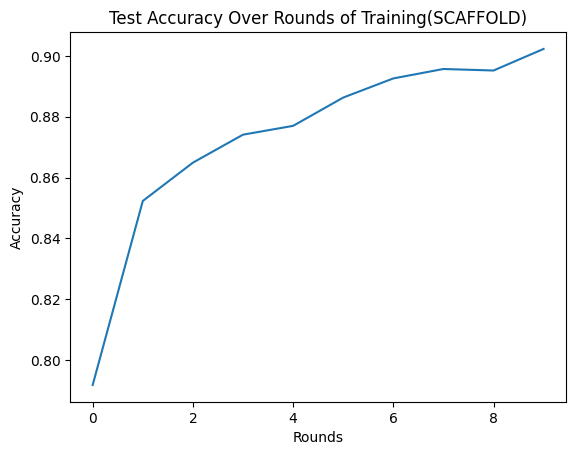

Final test accuracy: 0.9023000001907349


In [8]:
# 结果可视化：绘制训练过程中的准确率变化 Visualizing results: plotting accuracy changes during training
plt.plot(accuracy_history)
plt.title('Test Accuracy Over Rounds of Training(SCAFFOLD)')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.show()
print(f"Final test accuracy: {accuracy_history[-1]}")

In [9]:
print(f"Test accuracy: {accuracy_history}")

Test accuracy: [0.7918000221252441, 0.8522999882698059, 0.8648999929428101, 0.8741000294685364, 0.8769999742507935, 0.8863000273704529, 0.8925999999046326, 0.8956999778747559, 0.8952000141143799, 0.9023000001907349]
